# Optimizing spin squeezing parameter readout
_ Ilija Nikolov, Will Kaufman, December 2020_

In [467]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [492]:
I=3
(Ix, Iy, Iz) = qt.spin_J_set(I)

In [493]:
#The constants for our system
omegaQ = 4500 * 2*np.pi #7.58*2*np.pi*1e3
omegaL = 65.598*2*np.pi*1e6
omegaT = 1.58*2*np.pi*1e3
eta = omegaT/omegaQ

In [494]:
Hsys = omegaQ * Iz**2 / 2  # ignoring eta term for now

In [495]:
theta = np.pi/2
phi = np.pi

Calculate initial coherent state

In [496]:
vals = np.round(Iz.eigenstates()[0], 1)
vects = Iz.eigenstates()[1]
state = vects[0] - vects[0]
for i in range(len(vals)):
    state = state + np.sqrt(binom(2*I, I+vals[i])) *\
    (np.cos(theta/2))**(I-vals[i])*(np.sin(theta/2))**(I+vals[i]) *\
    np.exp(-1j*(I+vals[i])*phi)*vects[i]

ksi = state * state.dag()

In [497]:
times = np.arange(0, 1000e-6, 5e-6)

e_ops = [
    Ix, Iy, Iz,
    Iz**2-Iy**2,Iz*Iy+Iy*Iz, Iz**2+Iy**2
]
e_names = [
    r'$I_x$', r'$I_y$', r'$I_z$',
    r'$I_z^2 - I_y^2$', r'$I_zI_y + I_yI_z$', r'$I_z^2 + I_y^2$'
]
result = qt.mesolve(Hsys, ksi, times, e_ops=e_ops)

In [498]:
# for i, name in enumerate(e_names[:3]):
#     plt.plot(times, result.expect[i], label=name)
# plt.legend()
# for i, name in enumerate(e_names[3:]):
#     plt.plot(times, result.expect[i], label=name)
# plt.legend()

Calculate the squeezing parameter from `result` measurements.

In [499]:
xi = (
    np.sqrt(result.expect[5] - np.sqrt(result.expect[3]**2 + result.expect[4]**2))
    / np.sqrt(I)
)

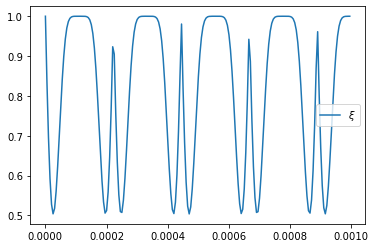

In [500]:
plt.plot(times, xi, label=r'$\xi$')
plt.legend()

**Question**: as can be seen in the plot below, for $I=3/2$ $\xi$ seems to have a parabolic-like relationship with $I_x$. In the $I=1$ case, the relationship appears to be $\xi \propto |I_x|$ (you can re-run the code above to see what that looks like). Whatever the relationship between $\xi$ and $I_x$ is, **as long as it's a single-valued function (passes the "vertical line test"), couldn't you measure $I_x$ then estimate $\xi$ based on a curve fit**?

Text(0, 0.5, '$\\xi$')

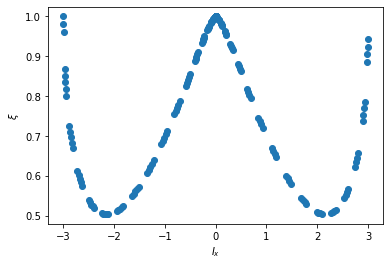

In [501]:
plt.scatter(result.expect[0], xi)
plt.xlabel(r'$I_x$')
plt.ylabel(r'$\xi$')

If you can simulate the relationship between $\xi$ and $I_x$ in QuTiP, then (if it's single-valued) use that to estimate $\xi$ from experimental data, that seems like the best option.

Below I tried to think about unitary transformations that will make a better parabolic fit between $\xi$ and $I_x$. but if you let the curve fit be general enough I don't think it's necessary to apply the transformation at all.

I looked at the $\xi$-$I_x$ relationship for different spins (3/2 through 7/2), and they all seem to have that single-valued relationship.

## Optimization algorithm

In [502]:
def get_hermitian_matrix(magnitudes, phases):
    """Make a Hermitian matrix by specifying the magnitudes
        and phases in the upper triangular part of the matrix.
    
    Args:
        magnitudes: An ndarray of length dim(dim+1)/2.
        phases: An ndarray of length dim(dim-1)/2.
    """
    dim = int((-1 + np.sqrt(1 + 8 * magnitudes.size))/2)
    # TODO make sure phases is right length too
    H = np.zeros((dim, dim), dtype=np.complex64)
    ind_upper = np.triu_indices(dim)
    H[ind_upper] = magnitudes
    ind_upper2 = np.triu_indices(dim, 1)
    H[ind_upper2] = H[ind_upper2] * np.exp(1j * phases)
    H = H + np.triu(H, 1).conj().T
    return H

In [503]:
def get_correlation(parameters):
    """Calculate the correlation between measurements specified
        by `parameters` and the squeezing parameter.
    
    Args:
        parameters: Should be length dim^2 array of
            magnitudes and phases specifying Hermitian matrix
    """
    dim = int(np.sqrt(parameters.size))
    H = get_hermitian_matrix(
        parameters[:int(dim*(dim+1)/2)],
        parameters[int(dim*(dim+1)/2):],
    )
    U = qt.Qobj(-1j * H).expm()
    guess = qt.mesolve(Hsys, ksi, times, e_ops=[U.dag() * Ix * U])
    corr = np.corrcoef(xi, guess.expect[0]**2)
    return -corr[0,1]

In [504]:
def get_fit(parameters):
    """Calculate the SSE for a polynomial fit of measurements
        specified by `parameters` to the squeezing parameter.
    
    Args:
        parameters: Should be length dim^2 array of
            magnitudes and phases specifying Hermitian matrix
    """
    dim = int(np.sqrt(parameters.size))
    H = get_hermitian_matrix(
        parameters[:int(dim*(dim+1)/2)],
        parameters[int(dim*(dim+1)/2):],
    )
    U = qt.Qobj(-1j * H).expm()
    guess = qt.mesolve(Hsys, ksi, times, e_ops=[U.dag() * Ix * U])
    result = np.polyfit(guess.expect[0], xi, deg=2, full=True)
    return result[1]

In [505]:
def get_propagator(amplitudes):
    """Calculate the propagator from time-dependent control
        Hamiltonians. In this case, the control Hamiltonians
        are Ix and Iy, which can perform rotations of the spin.
    
    Args:
        amplitudes: Array of control amplitudes. The first half
            of the array are amplitudes for Ix, and the second half
            are amplitudes for Iy.
    """
    n = int(amplitudes.size / 2)
    control_x_interp = interp1d(
        np.linspace(0, 1.1, n),
        amplitudes[:n],
        kind='cubic'
    )
    control_y_interp = interp1d(
        np.linspace(0, 1.1, n),
        amplitudes[n:],
        kind='cubic'
    )
    def control_x(t, args):
        return control_x_interp(t)
    def control_y(t, args):
        return control_y_interp(t)
    U = qt.propagator(
        [[Ix, control_x],
         [Iy, control_y]],
        1
    )
    return U

In [506]:
def get_fit_amplitudes(amplitudes):
    """
    Args:
        amplitudes: An array with control amplitude values.
            The first half are control amplitudes for Ix, and 
            the second half are for Iy.
    """
    U = get_propagator(amplitudes)
    result = qt.mesolve(Hsys, ksi, times, e_ops=[U.dag() * Ix * U])
    polyfit = np.polyfit(guess.expect[0], xi, deg=2, full=True)
    return polyfit[1]

In [507]:
# minimize_result = minimize(
#     get_fit_amplitudes,
#     np.random.normal(size=(10,), scale=.1),
#     method='nelder-mead',
#     options={'xatol': 1e-8, 'disp': True}
# )

In [508]:
# U = get_propagator(minimize_result.x)

In [509]:
# guess = qt.mesolve(Hsys, ksi, times, e_ops=[U.dag() * Ix * U])

In [510]:
# plt.plot(times, guess.expect[0], label=r'$\tilde{I_x}$')
# plt.legend()

In [511]:
# polyfit = np.polyfit(guess.expect[0], xi, deg=2, full=True)

In [512]:
# polyfit[0]

In [513]:
# plt.scatter(guess.expect[0], xi)
# plt.scatter(
#     guess.expect[0],
#     polyfit[0][0]*guess.expect[0]**2 + polyfit[0][1]*guess.expect[0] + polyfit[0][2])
# plt.xlabel(r'$I_x$')
# plt.ylabel(r'$\xi$')

In [514]:
# control_x_interp = interp1d(
#     np.linspace(0, 1.1, 5),
#     minimize_result.x[:5],
#     kind='cubic'
# )
# control_y_interp = interp1d(
#     np.linspace(0, 1.1, 5),
#     minimize_result.x[5:],
#     kind='cubic'
# )

In [515]:
# plt.plot(t, control_x_interp(t), label='x')
# plt.plot(t, control_y_interp(t), label='y')
# plt.legend()